In [1]:
import torch as t
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch.nn.functional as F
from datetime import datetime
from torch.autograd import Variable
from torchvision.utils import save_image
import imageio
import os
import math
seed = 7

In [27]:
transform = tv.transforms.Compose([tv.transforms.ToTensor()])

train_data = tv.datasets.MNIST("../../data/mnist",train=True, download=True, transform = transform)
test_data = tv.datasets.MNIST("data/test",train=False,download=True,transform=transform)

# kwargs = {'num_workers': 10, 'pin_memory': True} # GPU
kwargs = {'num_workers': 1, 'pin_memory': False} # CPU

train_loader = t.utils.data.DataLoader(train_data,batch_size=32,shuffle=True,**kwargs)
# test_loader = t.utils.data.DataLoader(test_data,batch_size=32,shuffle=True,**kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/test/MNIST/raw/train-images-idx3-ubyte.gz to data/test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/test/MNIST/raw/train-labels-idx1-ubyte.gz to data/test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/test/MNIST/raw/t10k-images-idx3-ubyte.gz to data/test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/test/MNIST/raw



In [28]:
train_data.targets
test_data.targets

tensor([7, 2, 1,  ..., 4, 5, 6])

In [29]:
print(t.bincount(train_data.targets, minlength=10))
print(t.bincount(test_data.targets, minlength=10))

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])


In [3]:
sampleX,sampleY = iter(train_loader).next()
print("The sample data shape is ",sampleX.shape,sampleY.shape)

The sample data shape is  torch.Size([32, 1, 28, 28]) torch.Size([32])


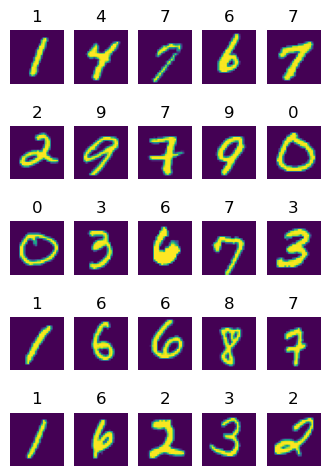

In [4]:
figure = plt.figure(figsize=(4,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis("off")
    plt.title(sampleY.numpy()[i])
    plt.imshow(sampleX.numpy()[i].squeeze())

In [5]:
use_cuda = t.cuda.is_available()
device = t.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

(60000, 1, 28, 28) (60000,)


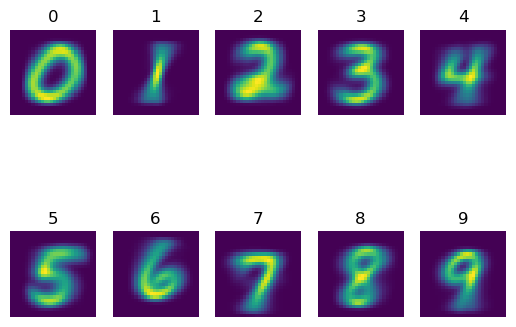

In [6]:
explore_X,explore_y = [],[]
for i in range(len(train_loader)):
    
    X,y = iter(train_loader).next()    
    explore_X.append(X.numpy())
    explore_y.append(y.numpy())
    
explore_X,explore_y = np.array(explore_X).reshape([60000,1,28,28]),np.array(explore_y).reshape([1875*32])
print(explore_X.shape,explore_y.shape)

def get_class_arrays(class_index):
    return explore_X[explore_y==class_index],explore_y[explore_y==class_index]

def get_mean_images():
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        mean_image = class_arrayX.mean(axis=0)
        plt.subplot(2,5,i+1)
        plt.axis("off")
        plt.title(i)
        plt.imshow(mean_image.squeeze())
        
get_mean_images()

In [7]:
def get_class_arrays(class_index):
    return explore_X[explore_y==class_index],explore_y[explore_y==class_index] 

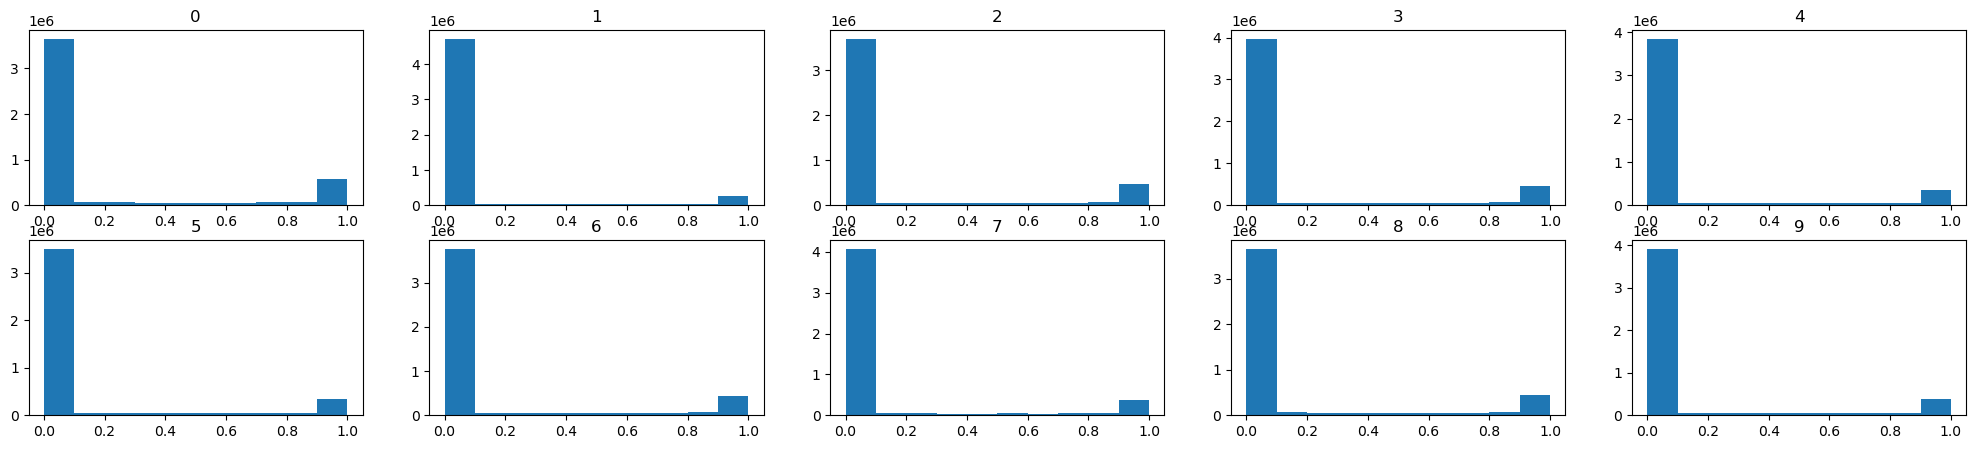

In [8]:
figure = plt.figure(figsize=(25,5))

def get_histogram():
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        plt.subplot(2,5,i+1)
        _ = plt.hist(class_arrayX.reshape(-1))
        plt.title(i)
get_histogram()

[0.17384176, 0.07614698, 0.14919448, 0.14091198, 0.12060931, 0.12806733, 0.137026, 0.1150799, 0.14991365, 0.12282427]


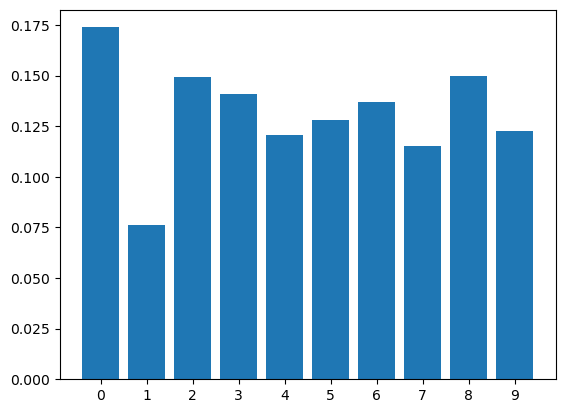

In [9]:
def get_mean_barchart():
    mean_values =[]
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        mean_values.append(class_arrayX.mean())
    
    plt.bar(np.arange(10),mean_values, align='center')
    plt.xticks(np.arange(10))
    print(mean_values)

get_mean_barchart()

In [10]:
explore_X.shape

(60000, 1, 28, 28)

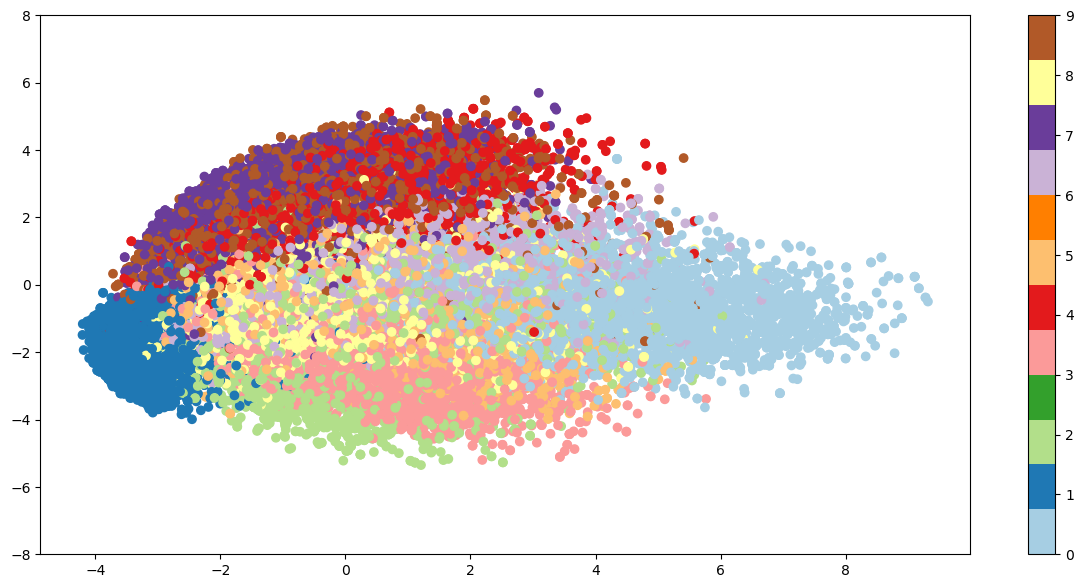

In [11]:
figure = plt.figure(figsize=(15,7))

pca = PCA(n_components=2)
proj = pca.fit_transform(explore_X.reshape(-1,784))
plt.scatter(proj[:, 0], proj[:, 1], c=explore_y, cmap="Paired")
plt.ylim([-8,8])
plt.colorbar(ticks=range(10))

In [12]:
from MulticoreTSNE import MulticoreTSNE as TSNE
embeddings = TSNE(n_jobs=2).fit_transform(explore_X.reshape(-1,784))

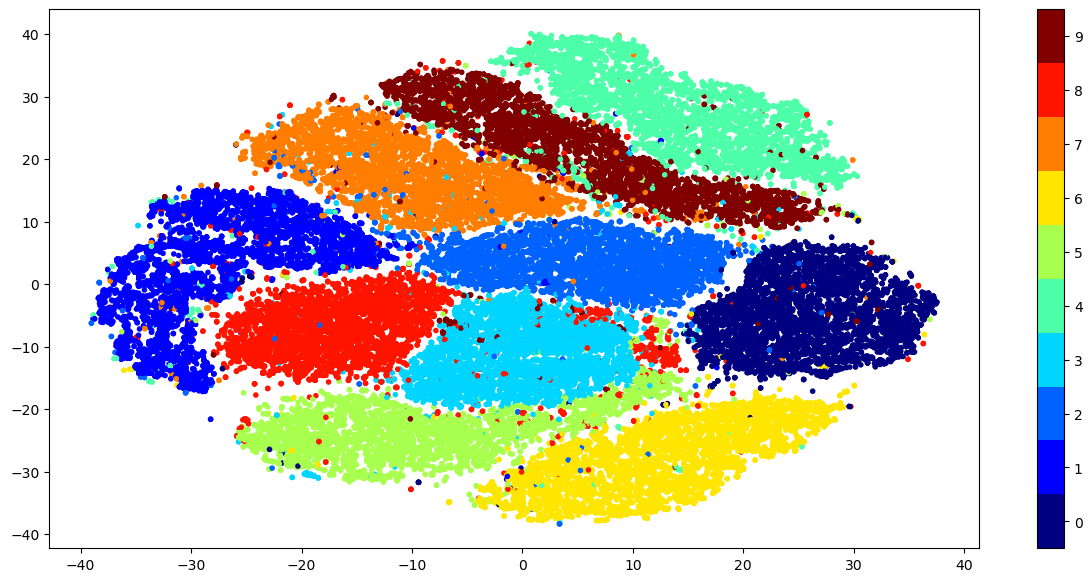

In [13]:
figure = plt.figure(figsize=(15,7))

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=explore_y, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

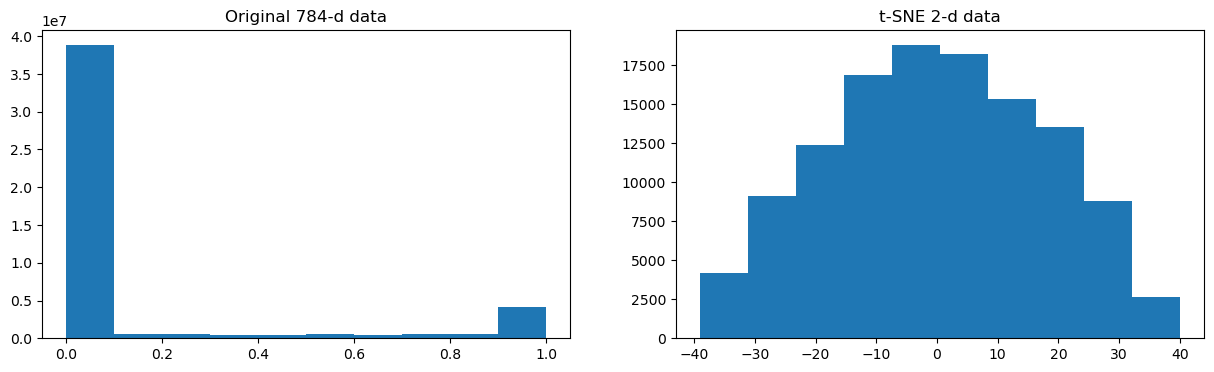

In [14]:
figure = plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
_= plt.hist(explore_X.reshape(-1))
plt.title("Original 784-d data")
plt.subplot(1,2,2)
_= plt.hist(embeddings.reshape(-1))
plt.title("t-SNE 2-d data")
plt.show()

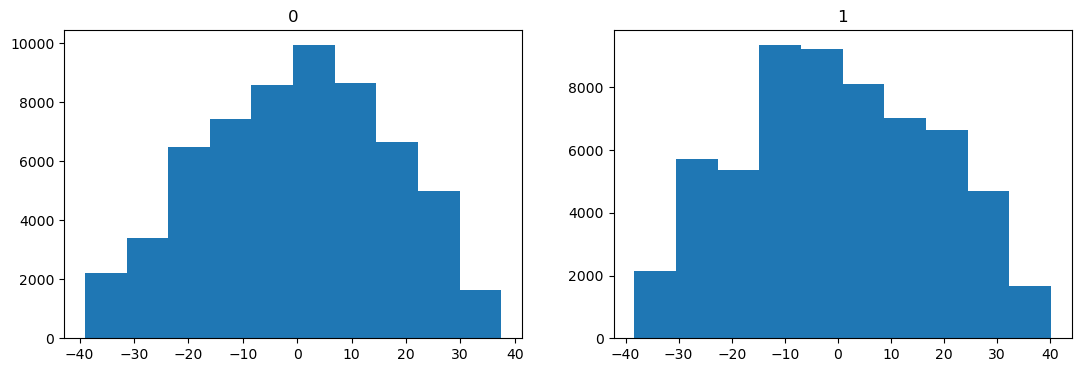

In [15]:
figure = plt.figure(figsize=(13,4))

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(i)
    _= plt.hist(embeddings[:,i])

In [16]:
def get_class_embeddings_arrays(class_index):
    return embeddings[explore_y==class_index],explore_y[explore_y==class_index]

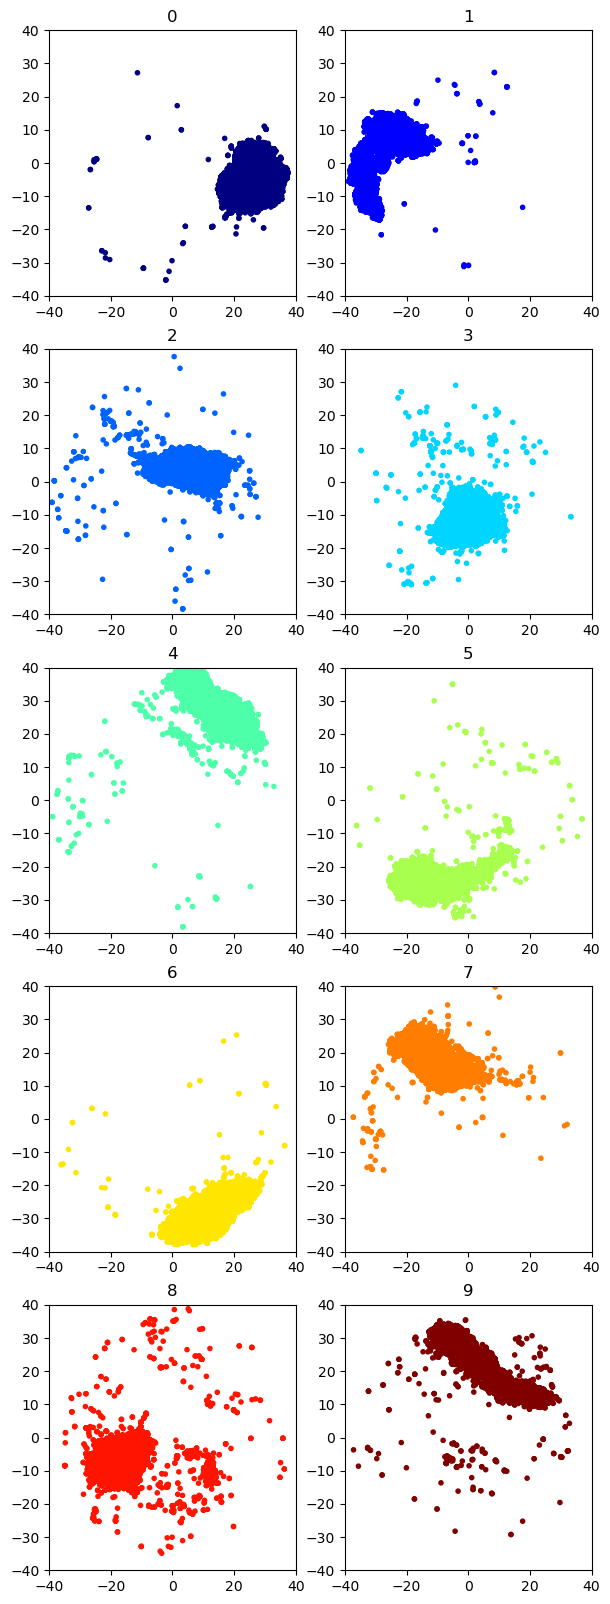

In [30]:
figure = plt.figure(figsize=(7,20))

for i in range(10):
    plt.subplot(5,2,i+1)
    class_embeddings_arrayX,class_embeddings_arrayY = get_class_embeddings_arrays(i)
    plt.scatter(class_embeddings_arrayX[:, 0], class_embeddings_arrayX[:, 1], c=class_embeddings_arrayY, 
                cmap=plt.cm.get_cmap("jet", 10), marker='.')
    plt.clim(-0.5, 9.5)
    plt.axis([-40, 40, -40, 40])
    plt.title(i)